In [ ]:
!wget http://images.cocodataset.org/zips/test2017.zip

--2021-04-30 03:58:34--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.242.116
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.242.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘test2017.zip’

test2017.zip        100%[===================>]   6.19G  45.7MB/s    in 2m 19s  

2021-04-30 04:00:54 (45.5 MB/s) - ‘test2017.zip’ saved [6646970404/6646970404]



In [ ]:
%rm -rf main

In [ ]:
!unzip test2017.zip -d /content/main

Streaming output truncated to the last 5000 lines.
 extracting: /content/main/test2017/000000251604.jpg  
 extracting: /content/main/test2017/000000145034.jpg  
 extracting: /content/main/test2017/000000234833.jpg  
 extracting: /content/main/test2017/000000025927.jpg  
 extracting: /content/main/test2017/000000393116.jpg  
 extracting: /content/main/test2017/000000536478.jpg  
 extracting: /content/main/test2017/000000365460.jpg  
 extracting: /content/main/test2017/000000089887.jpg  
 extracting: /content/main/test2017/000000274928.jpg  
 extracting: /content/main/test2017/000000310028.jpg  
 extracting: /content/main/test2017/000000229793.jpg  
 extracting: /content/main/test2017/000000394339.jpg  
 extracting: /content/main/test2017/000000564538.jpg  
 extracting: /content/main/test2017/000000440585.jpg  
 extracting: /content/main/test2017/000000541512.jpg  
 extracting: /content/main/test2017/000000395525.jpg  
 extracting: /content/main/test2017/000000235435.jpg  
 extracting: /

In [ ]:
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

--2021-04-30 04:13:39--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘vgg16-00b39a1b.pth’

vgg16-00b39a1b.pth  100%[===================>] 527.81M  53.8MB/s    in 11s     

2021-04-30 04:13:50 (47.9 MB/s) - ‘vgg16-00b39a1b.pth’ saved [553451520/553451520]



In [3]:
import torch 
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torchvision import datasets
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random

In [4]:
def load_image(path):
    img = cv2.imread(path)
    return img


In [5]:
def show(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = np.array(img / 255).clip(0, 1)
  plt.imshow(img)
  plt.show()

In [6]:
def save_image(img, path):
  img = img.clip(0, 255)
  cv2.imwrite(path, img)

In [7]:
def itoi(img, max_size = None):
  if max_size == None:
    tfs = transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Lambda(lambda x: x.mul(255))
    ])

  else:
    H, W, C = img.shape
    img_size = tuple([int((float(max_size) / max(H, W))*x) for x in [H, W]])
    tfs = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Resize(img_size),
                              transforms.ToTensor(),
                              transforms.Lambda(lambda x: x.mul(255))
    ])

  return tfs(img)

In [8]:
def toti(tensor):
  tensor = tensor.squeeze()
  img = tensor.cpu().numpy()
  return img.transpose(1, 2, 0)
  

In [11]:
class TransformerNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        conv_layer(3, 32, 9, 1),
        conv_layer(32, 64, 3, 2),
        conv_layer(64, 128, 3, 2),
        ResBlock(128, 3),
        ResBlock(128, 3),
        ResBlock(128, 3),
        ResBlock(128, 3),
        DeConv(128, 64, 3, 2, 1),
        nn.ReLU(),
        DeConv(64, 32, 3, 2, 1),
        nn.ReLU(),
        conv_layer(32, 3, 9, 1)[:-2]
    )

  def forward(self, x):
    return self.main(x)

In [12]:
def conv_layer(in_ch, out_ch, kernel_size, stride):
  rp = kernel_size // 2
  return nn.Sequential(
      nn.ReflectionPad2d(rp),
      nn.Conv2d(in_ch, out_ch, kernel_size, stride),
      nn.InstanceNorm2d(out_ch, affine = True),
      nn.ReLU()
  )

In [13]:
class ResBlock(nn.Module):

  def __init__(self, channels = 128, kernel_size = 3):
    super().__init__()
    self.conv1 = conv_layer(channels, channels, kernel_size, stride = 1)
    self.conv2 = conv_layer(channels, channels, kernel_size, stride = 1)[:-1]
  
  def forward(self, x):
    return x + self.conv2(self.conv1(x))

In [14]:
class DeConv(nn.Module):

  def __init__(self, in_ch, out_ch, kernel_size, stride, out_padding):
    super().__init__()
    padding_size = kernel_size // 2
    self.convT = nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride, padding_size, out_padding)
    self.norm = nn.InstanceNorm2d(out_ch, affine = True)

  def forward(self, x):
    return self.norm(self.convT(x))


In [11]:
class VGG16(nn.Module):
    def __init__(self, vgg_path="models/vgg16-00b39a1b.pth"):
        super(VGG16, self).__init__()
        vgg16_features = models.vgg16(pretrained=False)
        vgg16_features.load_state_dict(torch.load(vgg_path), strict=False)
        self.features = vgg16_features.features

        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        layers = {'3': 'relu1_2', '8': 'relu2_2', '15': 'relu3_3', '22': 'relu4_3'}
        features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
                if (name=='22'):
                    break

        return features

In [12]:
def gram_matrix(data):
  b, c, h, w = data.shape
  x = data.view(b, c, h*w)
  xt = x.transpose(1, 2)
  return torch.bmm(x, xt) / (c * w * h)

In [13]:
def tv_loss(img_batch):
    batch_size = img_batch.shape[0]
    return (torch.sum(torch.abs(img_batch[:, :, :, :-1] - img_batch[:, :, :, 1:])) + torch.sum(torch.abs(img_batch[:, :, 1:, :] - img_batch[:, :, :-1, :]))) / batch_size

In [14]:
IMG_SIZE = 256
DATASET_PATH = '/content/main'
BATCH_SIZE = 4
CONTENT_WEIGHT = 10
STYLE_WEIGHT = 75
LR = 1e-3
SEED = 35
'''
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
'''

'\ntorch.manual_seed(SEED)\ntorch.cuda.manual_seed(SEED)\nnp.random.seed(SEED)\nrandom.seed(SEED)\n'

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
transform = transforms.Compose([
                                transforms.Resize(IMG_SIZE),
                                transforms.CenterCrop(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.mul(255))
])

In [17]:
train_dataset = datasets.ImageFolder(DATASET_PATH, transform)
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle = True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/main'

In [ ]:
imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)

In [14]:
style_image = load_image('mosaic2.jpg')

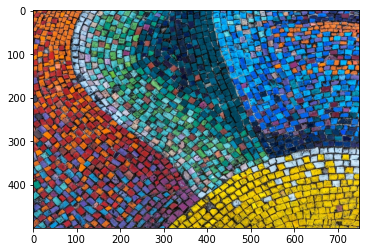

In [15]:
show(style_image)

In [ ]:
style_tensor = itoi(style_image).to(device).add(imagenet_neg_mean)

In [ ]:
t_net = TransformerNet().to(device)

In [ ]:
b, c, h, w = style_tensor.shape

In [ ]:
style_features = vgg(style_tensor.expand([BATCH_SIZE, c, h, w]))

In [ ]:
style_gram = {}
for key, value in style_features.items():
  style_gram[key] = gram_matrix(value)

In [ ]:
optimizer = torch.optim.Adam(t_net.parameters(), lr = LR)

In [ ]:
criterion = nn.MSELoss().to(device)

Content_loss = inf
Style_loss = inf


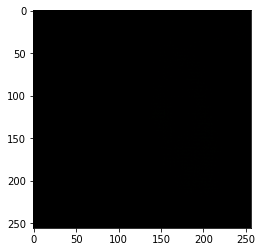

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2858873.5
Style_loss = 34859168.0


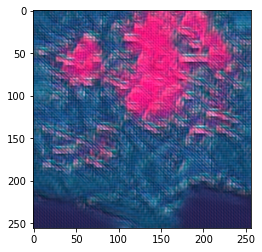

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2764715.0
Style_loss = 18337244.0


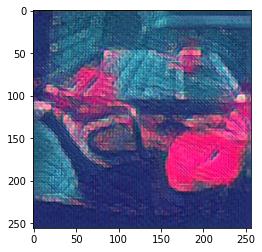

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2649309.25
Style_loss = 12621282.0


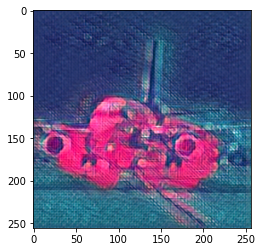

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2557322.5
Style_loss = 9722981.0


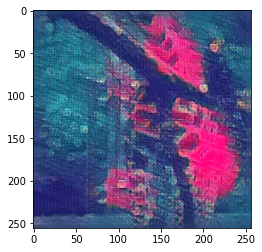

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2479030.0
Style_loss = 7960569.0


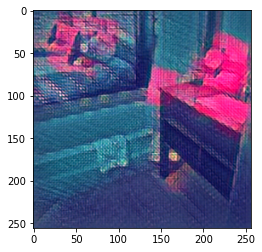

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2409254.0
Style_loss = 6773278.0


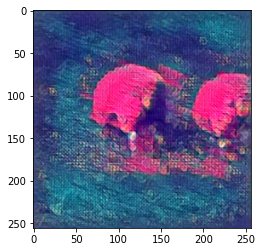

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2349746.5
Style_loss = 5920065.0


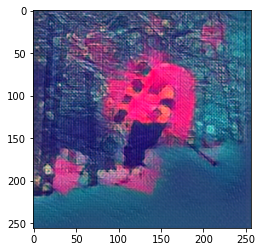

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2296676.75
Style_loss = 5276043.5


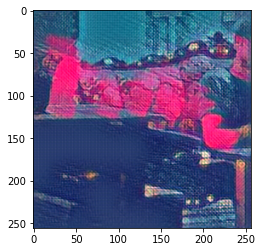

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2250281.0
Style_loss = 4772887.0


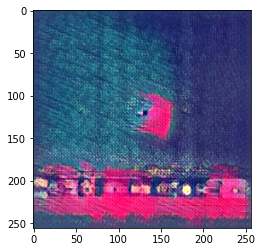

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2208533.75
Style_loss = 4366234.5


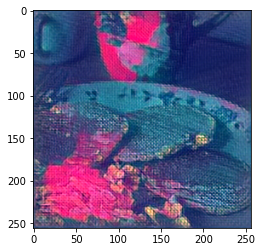

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2170294.75
Style_loss = 4031906.0


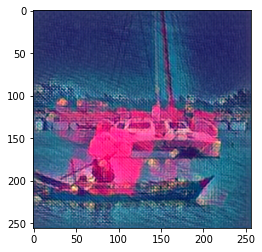

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2136810.75
Style_loss = 3752937.75


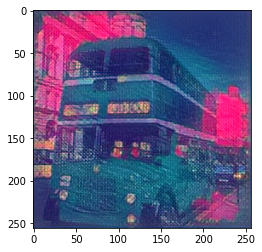

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2107266.5
Style_loss = 3515790.75


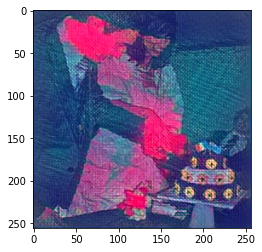

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2080338.875
Style_loss = 3310795.5


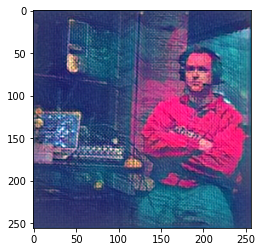

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2055341.75
Style_loss = 3132303.75


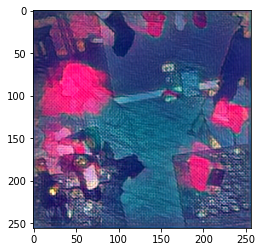

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2031858.375
Style_loss = 2975434.25


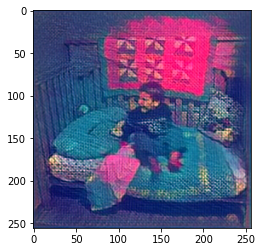

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 2011079.125
Style_loss = 2836790.0


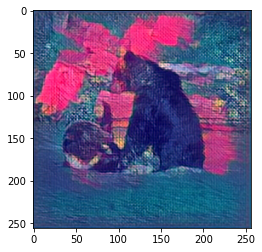

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1991407.875
Style_loss = 2712893.5


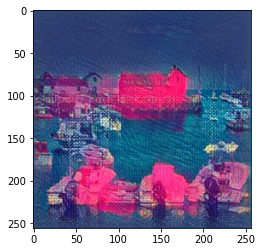

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1972503.75
Style_loss = 2601543.0


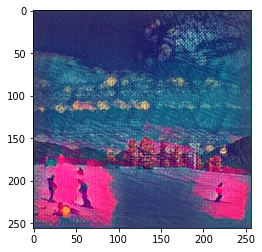

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1954913.625
Style_loss = 2500829.0


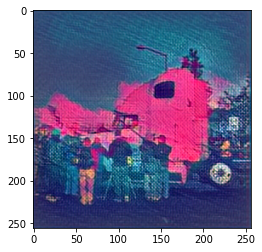

########################################################################################################################################################################Content_loss = 1949557.5
Style_loss = 2469059.5


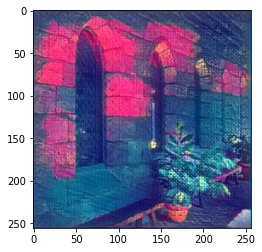

############################################################################################################################################################################################################################################################################################################################################Content_loss = 1938871.625
Style_loss = 2409137.0


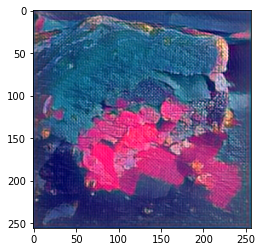

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1924065.625
Style_loss = 2325729.75


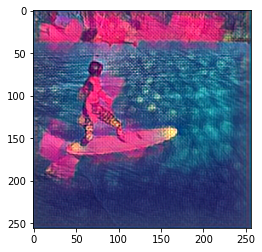

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1910394.5
Style_loss = 2249224.25


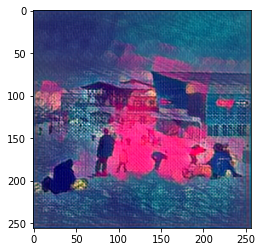

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1897337.375
Style_loss = 2178872.75


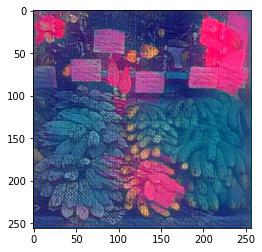

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1885164.625
Style_loss = 2113724.75


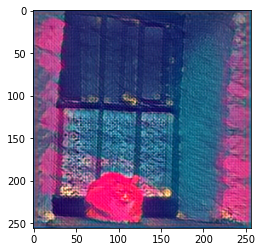

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1873160.75
Style_loss = 2053623.875


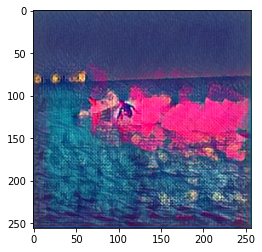

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1862259.875
Style_loss = 1997993.25


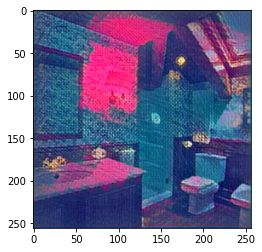

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1852230.5
Style_loss = 1946005.625


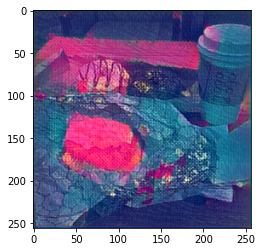

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1842133.125
Style_loss = 1897349.5


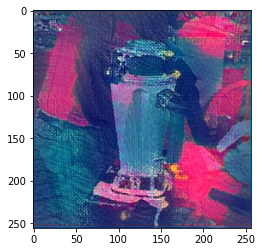

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1833197.375
Style_loss = 1852390.5


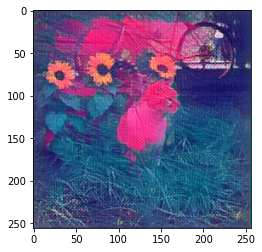

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1823949.125
Style_loss = 1809698.125


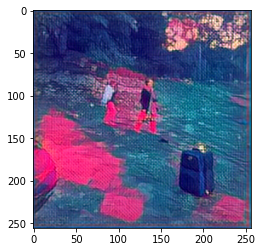

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1815295.625
Style_loss = 1769490.875


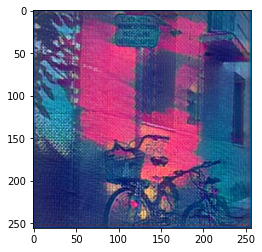

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1806780.5
Style_loss = 1731632.125


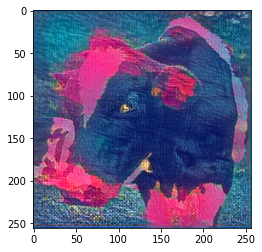

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1799254.25
Style_loss = 1696034.0


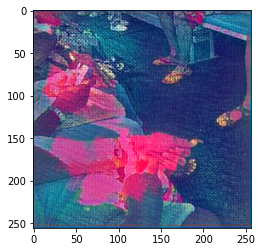

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1791854.25
Style_loss = 1662388.75


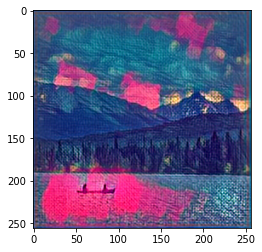

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1784604.375
Style_loss = 1630519.875


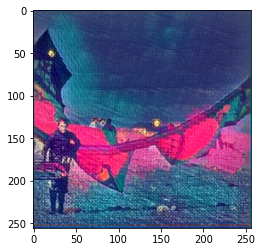

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1777714.0
Style_loss = 1600236.375


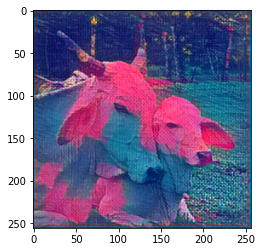

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1771025.375
Style_loss = 1571434.125


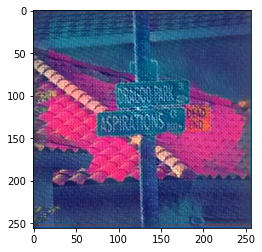

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1764817.875
Style_loss = 1544006.125


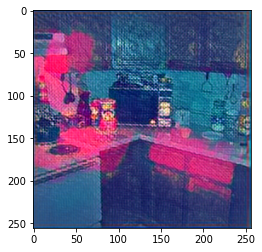

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 1758569.25
Style_loss = 1518031.125


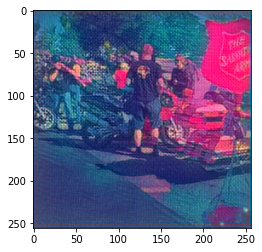

################################################################################################################################################################################################################################################################################################################################################

In [ ]:
batch_con_loss = 0
batch_style_loss = 0
batch_count = 0

for e in range(2):

  for batch_id, (content_batch, _) in enumerate(train_loader):

    batch_size = content_batch.shape[0]

    optimizer.zero_grad()

    content_batch = content_batch[:, [2, 1, 0]].to(device)

    y = t_net(content_batch)

    content_features = vgg(content_batch.add(imagenet_neg_mean))
    generated_features = vgg(y.add(imagenet_neg_mean))

    content_loss = CONTENT_WEIGHT * criterion(generated_features['relu2_2'], content_features['relu2_2'], )
    batch_con_loss += content_loss

    style_loss = 0

    for key, value in generated_features.items():
      style_loss += criterion(gram_matrix(value), style_gram[key][:batch_size])
    style_loss *= STYLE_WEIGHT
    batch_style_loss += style_loss

    loss = content_loss + style_loss

    loss.backward()
    optimizer.step()

    if batch_count % 500 == 0 or batch_count == len(train_loader):
      print(f'Content_loss = {batch_con_loss/batch_count}')
      print(f'Style_loss = {batch_style_loss/batch_count}')

      torch.save(t_net.state_dict(), f'stage{batch_count}.pt')

      temp = y[0].clone().detach().unsqueeze(0)
      out = toti(temp)
      show(out)

    batch_count += 1    
    print('#', end='')

In [33]:
 def stylize():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = TransformerNet().to(device)
  model.load_state_dict(torch.load('models/painting3.pt', map_location = device))
  with torch.no_grad():
    torch.cuda.empty_cache()
    content_image = load_image('images/stanford.jpg')
    content_tensor = itoi(content_image, 800).unsqueeze(0).to(device)
    print(content_tensor.shape)
    gen_tensor = model(content_tensor)
    gen_image = toti(gen_tensor)
    show(gen_image)
    save_image(gen_image, './output.jpg')


torch.Size([1, 3, 533, 800])


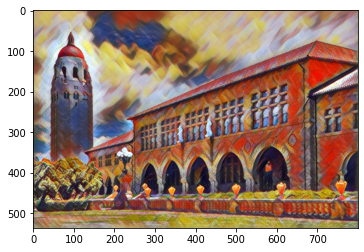

In [34]:
stylize()